# Introduzione

La statistica bayesiana si fonda sul **teorema di Bayes** la cui formulazione nel caso di variabili discrete è enunciata di seguito:

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

ove:
- P(A) è la probabilità che si verifichi l'evento A. Analogamente per P(B)
- P(A|B) è la probabilità che si verifichi l'evento A dopo che sia verificato l'evento B

Possiamo interpretare il teorema di Bayes in diversi modi.

## Interpretazione 1

Gli eventi A e B si riferiscono al valore assunto da due variabili casuali: $X_1$ e $X_2$.

L'evento A potrebbe essere che $X_1$ assume un valore maggiore di 100.
L'evento B potrebbe essere che $X_2$ assume il valore 10.

Posto che si è verificato l'evento A ($X_1>100$), quale è la probabilità che si verifichi l'evento B ($X_2 = 10$)?

## Interpretazione 2

Ho una variabile casuale X che cambia nel tempo. E gli eventi A e B sono i valori in due diversi istanti di tempo. 
Il valore della prima osservazione è B.  

Verificatosi l'evento X=B, quale è la probabilità che alla seconda osservazione si verifichi l'evento X=A?

L'esempio più che classico è quello del lancio della moneta. Se ho lanciato la moneta 2 volte e per 2 volte è uscito testa, quale è la probabilità che al terzo lancio esca nuovamente testa. 

## Interpretazione 3

Questa interpretazione si usa spesso nel campo della ricerca medica e scientifica.

Dato il risultato B al test, quale è la probabilità che la misura vera sia A.

Per esempio, quale è la probabilità che il paziente abbia la malattia X (evento A), posto che il paziente sia risultato positivo al test per la malattia X (evento B).


# Applicazioni di statistica bayesiana

Nella sua formulazione più generica, ove le variabili casuali sono continue, la formulazione del teorema di Bayes è:

\begin{equation}
f(x|y) = \frac{f(y|x)f(x)}{\int f(y|x)f(x) dx}
\end{equation}

dove:
- f(x|y) è la funzione densità probabilità di x condizionata da y
- f(y|x) è la funzione densità probabilità di y condizionata da x. È anche chiamata verosimiglianza (*likelihood*)
- f(x) è la densità di probabilità di x

Si noti l'abuso di notazione, in cui tutte le funzioni (anche se si tratta di funzioni diverse) sono indicate con $f()$. 

L'integrale al denominatore nei casi più generici è impossibile da calcolare in forma chiusa. Per questo motivo la statistica bayesiana è rimasta in secondo piano fino a che i computer non hanno reso possibile il calcolo numerico dell'integrale.

Il pacchetto [PyMC3](https://docs.pymc.io/) per Python consente di implementare modelli bayesiani e generare dati sulla base dei modelli definiti. 

Questo viene usualmente definito come programmazione probabilistica (*probabilistic programming*).

Lo schema che seguiremo è semplice:

- ho dei dati empirici di partenza $X=\{x_1,x_2,x_3,\dots,x_n\}$
- definisco una distribuzione a priori: $X \sim f(x)$
- i dati empirici vengono inglobati nel modello, generando una distribuzione a posteriori 
- uso il modello per generare (**simulare**) nuove osservazioni di $X$ 

Per l'installazione di PyMC3 si può fare riferimento al sito ufficiale, alla pagina [getting started](https://docs.pymc.io/notebooks/getting_started.html). Poiché ho avuto qualche problema nell'installazione ho indicato in calce a questo post una lista di [dipendenze](#Dipendenze), indicando precisamente quale versione è necessaria per ciascun package.

Importiamo i package che ci servono.

In [1]:
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import arviz as az
import numpy as np

# import warnings
# warnings.filterwarnings("ignore")

## Esempio 1

Quanto è la probabilità $p$ che venga testa quando lancio una moneta bilanciata?

Un <strong>esperimento di Bernoulli</strong> è un esperimento il cui risultato può essere 0 o 1. <br> 
Per esempio, il risultato $X$ del lancio della moneta è una distribuzione di Bernoulli con paramentro $p$. $X$ è pari ad 1 se viene testa, è pari a 0 se viene croce:

$$
X \sim Ber(p)
$$

La distribuzione di probabilità di Bernoulli è:

$$
f(x) = 
\begin{cases}
1-p  & \text{if } x=0 \cr
p & \text{if } x=1
\end{cases}
$$

oppure in maniera più compatta:

$$
f(x) = p^x(1-p)^{1-x}
$$

dove $p$ è la probabilità che il risultato del singolo lancio sia testa. Ammesso di conoscere $p$. Nel nostro caso anche $p$ è una variabile random. Vediamo se grazie alla statistica bayesiana riesco a trovare un valore per $p$ e ad esprimere il grado di sicurezza sul valore di $p$.

Per la teoria di Bayes devo definire una probabilità a priori per $p$. Poiché non ho idea di che razza di monetina si tratti (sono tempi duri) decido la probabilità a priori di p sia distribuita uniformemente tra 0 e 1.
$$
p \sim U(0,1)
$$

### La teoria

I passi sono i seguenti:
- definisco una probabilità a priori per $p$
- definisco la funzione di verosimiglianza per $X$, ovvero come è distribuita $X$ nel caso in cui conosco $p$
- eseguo il primo esperimento: ottengo il valore $X_1$
- calcolo la probabilità a posteriori di $p|X_1$
- uso questa probabilità a posteriori come probabilità a priori del prossimo esperimento (la funzione di verosimigianza è la stessa)
- eseguo il secondo esperimento: ottengo il valore $X_2$
- calcolo la nuova probabilità a posteriori $p|X_2,X_1$
- e proseguo in questo modo, aggiornando la probabilità a posteriori dopo ogni nuovo esperimento.


Vediamo come funziona per un caso semplice. Come detto per $p$ scegliamo una distribuzione uniforme, mentre per X una distribuzione di Bernoulli.

$
p \sim U(0,1) \Rightarrow f(p) = I_{\{0\le p \le 1\}} = 
\begin{cases}
1 & \text{se } 0 \le x \le 1 \cr
0 & \text{altrove }
\end{cases}
$

$
X \sim Ber(p) \Rightarrow f(x|p) = p^x(1-p)^{1-x}
$

Per il teorema di Bayes risulta:

\begin{equation}
f(p|x) = \frac{f(x|p)f(p)}{\int f(x|p)f(p) dp}
\end{equation}

Iniziamo con il calcolare l'integrale:
\begin{equation}
\int f(x|p)f(p) dp = \int_{-\infty}^\infty p^x(1-x)^{1-x} I_{\{0\le p \le 1\}}  dp = \int_0^1 p^x(1-x)^{1-x} dp =
\begin{cases}
\left[1-\frac{p^2}{2} \right]_0^1  & \text{se } x=0 \\
\left[\frac{p^2}{2} \right]_0^1 & \text{se } x=1
\end{cases} = 
\begin{cases}
\frac{1}{2} & \text{se } x=0 \\
\frac{1}{2} & \text{se } x=1
\end{cases} = 
\frac{1}{2}
\end{equation}

Il primo esperimento da $X_1 = 1$.
Sostituiamo il tutto nella equazione di Bayes: 

\begin{equation}
f(p|x) = \frac{f(x|p)f(p)}{\int f(x|p)f(p) dp} = \frac {p^x(1-p)^{1-x}}{1/2} I_{\{0\le p \le 1\}} \Bigg]_{X_1=1} = 2p\text{ }I_{\{0\le p \le 1\}}
\end{equation}

Questo significa che la densità di probabilità si è spostata su valori alti di p (vedi figura sotto). Questo è logico perché dopo una volta che esce testa, obbiettivamente dovrei presumere che la testa esca più di frequente. 

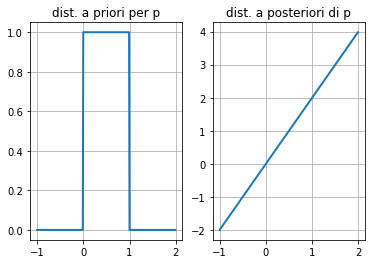

In [2]:
x_axis = np.arange(-1, 2, 0.01)
p_prior = np.concatenate((np.zeros((100)),np.ones((100)),np.zeros((100))))
p_post = 2*x_axis
plt.subplot(121)
plt.plot(x_axis, p_prior,lw=2)
plt.grid()
plt.title('dist. a priori per p')
plt.subplot(122)
plt.plot(x_axis, p_post,lw=2)
plt.grid()
plt.title('dist. a posteriori di p')
plt.show()

Se ho $X_2 = 1$ mi aspetto che la "convinzione" del modello che il risultato testa sia favorito aumenti ancora.


\begin{equation}
\int f(x|p) f(p) dp = \int_{-\infty}^\infty p^x(1-x)^{1-x} \times 2p \text{ }I_{\{0\le p \le 1\}} dp\Bigg]_{X_2=1} = \int_{0}^1 (p \times 2p) dp = \left[ 2 \frac{p^3}{3} \right]_0^1 = \frac{2}{3}
\end{equation}

\begin{equation}
f(p|x) = \frac{f(x|p)f(p)}{\int f(x|p)f(p) dp} = \frac {p^x(1-p)^{1-x} \text{ } 2p}{2/3} I_{\{0\le p \le 1\}} \Bigg]_{X_2=1} = 3p^2\text{ }I_{\{0\le p \le 1\}}
\end{equation}

Possiamo visualizzare la nuova distribuzione a posteriori. La densità di probabilità che venga testa si sposta ancora più verso l'alto. 

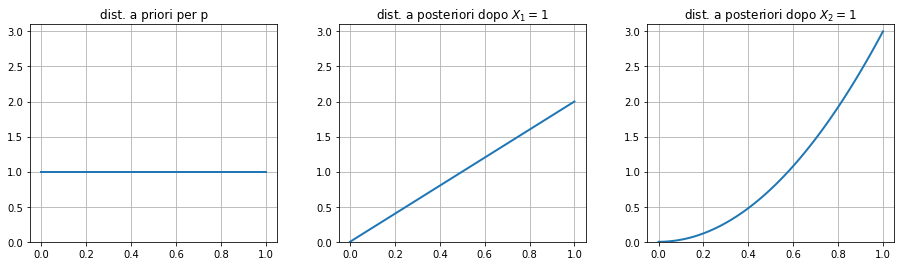

In [3]:
x_axis = np.arange(0, 1.01, 0.01)
p_prior = np.ones((x_axis.shape[0]))
p_post = 2*x_axis
p_post_2 = 3* np.power(x_axis,2)
ax = plt.subplot(131)
plt.plot(x_axis, p_prior,lw=2)
plt.grid()
plt.title('dist. a priori per p')
plt.ylim(0,3.1)
plt.subplot(132)
plt.plot(x_axis, p_post,lw=2)
plt.grid()
plt.title('dist. a posteriori dopo $X_1=1$')
plt.ylim(0,3.1)
plt.subplot(133)
plt.plot(x_axis, p_post_2,lw=2)
plt.grid()
plt.title('dist. a posteriori dopo $X_2=1$')
plt.ylim(0,3.1)
plt.subplots_adjust(left=11,right=13,wspace=0.25)
plt.show()

Come si vede anche in un caso semplice come questo, occorre sempre calcolare degli integrali. Nel nostro caso addomesticato si possono ancora gestire. Ma in un caso più generale possono non avere una soluzione chiusa.

Inoltre ci sono una serie di problemi che possono essere risolti in forma chiusa, usando distribuzione a priori coniugate.

Ma questo è, per i miei gusti, restrittivo e comunque matematicamente impegnativo, pertanto decido di usare **Pymc3**.



### Il modello in Pymc3

Analizziamo lo stesso problema del lancio della monetina con PyMC3.

La prima cosa da fare è **definire un modello**, questo comprende variabili dipendenti ed indipendenti. Una di queste variabili è **confrontata** con i dati empirici. Nel senso che la variabile deve rappresentare (e predire) i dati empirici. 

In questo notebook simulo i dati empirici come samples di una **distribuzione di Bernoulli**, per questo utilizzo **stats.bernoulli** e **rvs** per generare una sequenza di casuale di 500 numeri. $X_{obs}$ è l'array contenente i dati osservati.

In [4]:
X_obs = stats.bernoulli.rvs(0.5, size=500)
np.mean(X_obs)

0.536

È il momento di definire il modello probabilistico **pm.Model()**.

Come discusso in precedenza i risultati (testa o croce) sono distribuiti secondo una distribuzione di Bernoulli, in cui la probabilità che esca testa è $p$. Quest'ultima è una incognita, sulla quale non ho informazioni e non voglio azzardare alcuna ipotesi, per cui posso dire che $p$ è una variabile random con una **probabilità a priori** che è una distribuzione uniforme (tra 0 e 1):
\begin{equation}
p \sim U(0,1)
\end{equation}
Per $p$ uso la funzione **pm.Uniform()**.

La distribuzione dei risultati $X$, nota la probabilità $p$ è:
\begin{equation}
X \sim Ber(p) \Rightarrow f(x|p) = p^x(1-p)^{1-x}
\end{equation}

Per $X$ uso la funzione **pm.Bernoulli**, che richiede come parametri la proabilità $p$ (anch'essa una variabile random) e i valori osservati.

Questa descrizione del modello viene raccolta nella seguente notazione.
 
Con il metodo **pm.sample()** genero un numero di campioni (di $p$) pari a *draws* della distribuzione a posteriori di $p$.

In [5]:
with pm.Model() as model:
    p = pm.Uniform('p', 0, 1)
    X = pm.Bernoulli('X', p=p, observed=X_obs)
    
    trace_m = pm.sample(draws=1000, tune=1000, cores=12, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 12 jobs)
NUTS: [p]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1554.86draws/s]


Il metodo **pm.plot_trace** visualizza le tracce (o *chains*) generate da **pm.sample()**, a destra ho il valore dei campioni e a sinistra la distribuzione degli stessi per ciascuna delle tracce.

C:\Users\home\Anaconda3\envs\pymc34\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


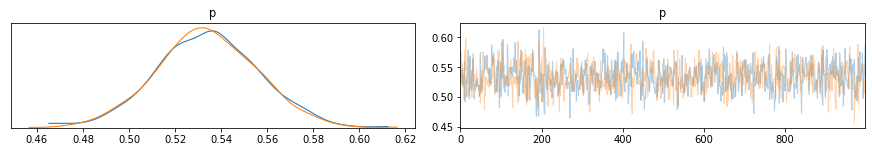

In [6]:
az.plot_trace(trace_m)
plt.show()

Visualizzo la densità di probabilità di $p$, con l'intervallo di credibilità al 94%.

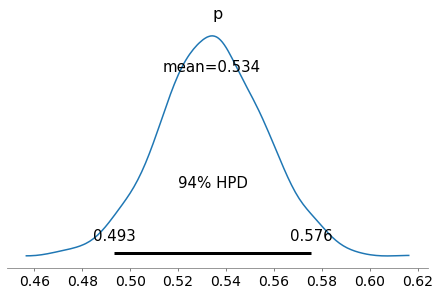

In [7]:
az.plot_posterior(trace_m, round_to=3)
plt.show()

Facendo una simulazione con un numero maggiore di campioni ottengo due tracce con distribuzioni (ad occhio) gaussiane pressoché identica.

In [8]:
with pm.Model() as model:
    p = pm.Uniform('p', 0, 1)
    X = pm.Bernoulli('X', p=p, observed=X_obs)
    
    trace_m = pm.sample(draws=100000, tune=2000, cores=8, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [p]
Sampling 2 chains: 100%|██████████████████████████████████████████████████| 204000/204000 [00:49<00:00, 4111.51draws/s]


C:\Users\home\Anaconda3\envs\pymc34\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


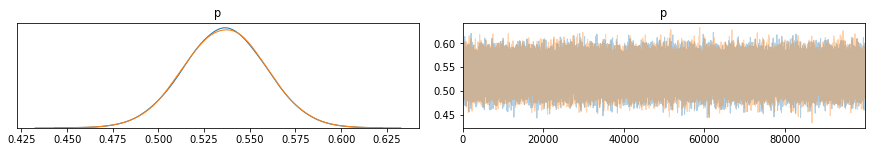

In [9]:
az.plot_trace(trace_m)
plt.show()

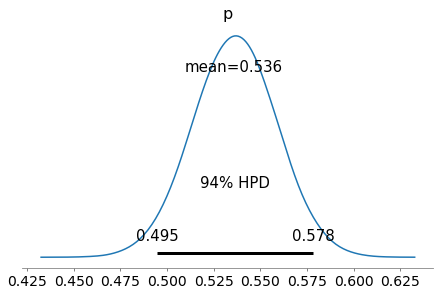

In [10]:
az.plot_posterior(trace_m,round_to=3,)
plt.show()

Se cambio i dati osservati, e questa volta uso una probabilità $p=0.25$, una monetina piuttosto sbilanciata, con lo stesso modello questa volta la distribuzione a posteriori di $p$ converge su una distribuzione con un intervallo di credibilità che contiene 0.25. Non si può non notare che l'intervallo non è molto centrato su 0.25, da cosa dipende?

In [11]:
X_obs = stats.bernoulli.rvs(0.25, size=500)

In [12]:
with pm.Model() as model:
    p = pm.Uniform('p', 0, 1)
    X = pm.Bernoulli('X', p=p, observed=X_obs)
    
    trace_m = pm.sample(draws=1000, tune=1000, cores=8, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [p]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1561.89draws/s]


C:\Users\home\Anaconda3\envs\pymc34\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


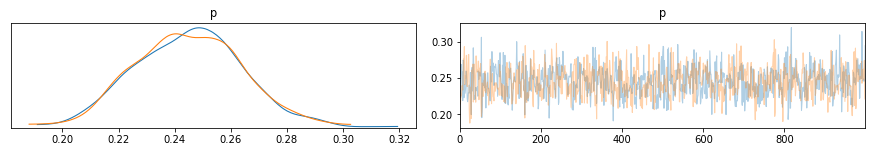

In [13]:
pm.plot_trace(trace_m)
plt.show()

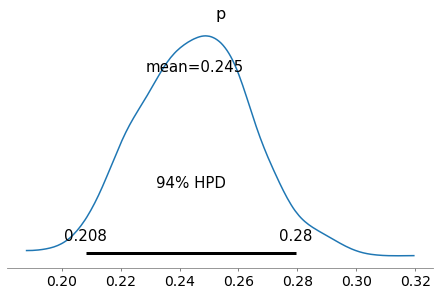

In [14]:
pm.plot_posterior(trace_m,round_to=3)
plt.show()

## Esempio 2

### Generare il dataset

Generiamo un dataset fittizio, preso da una distribuzione normale con valor medio 100 e varianza 20.

Questo dataset potrebbe per esempio rappresentare una misura di una quantità in un ambiente dove il rumore del sistema è elevato. Potrebbe essere che in sé il sistema è rumoroso e quindi quello che abbiamo immaginato come un valore statico in realtà non esiste proprio. Potrebbe anche essere che il sistema di misura è affetto dal rumore.

Quale che sia la causa, il mio compito è quello di dare un valore per la misura e magari un intervallo di confidenza, o come si dice in termini di statistica bayesiana un intervallo di credibilità.

Per la generazione del dataset uso la semplice funzione di numpy <strong>np.random.normal</strong>

In [15]:
import numpy as np
y_obs = np.random.normal(loc=100, scale=20, size=200)

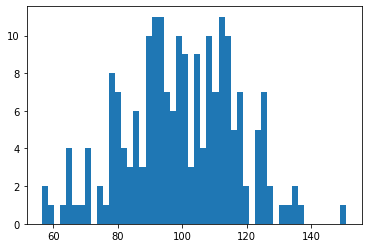

In [16]:
import matplotlib.pyplot as plt
plt.hist(y_obs,bins=50)
plt.show()

### Definiamo il modello Pymc3

La variabile y è una variabile random centrata su un valore medio, la sua distribuzione è approssimativamente normale (lo vediamo dai dati osservati y_obs).
Pertanto uso una funzione di verosimiglianza normale per i dati y.


y è normale con media $mu$ e varianza $sigma$, che però anche esse sono incognite. Le possiamo rappresentare con variabili random aventi una distribuzione che definiamo probabilità a priori.

Nella definizione delle probabilità a priori, riverso le mie convinzioni o conoscenze su $mu$ e $sigma$.<br>
In questo caso la media $mu$ potrebbe nel range di valori centrali di y_obs (vedi plot sopra), ma decido di non favorire nessun valore del range, per cui dico che $mu$ è distribuito uniformemente tra 80 e 130.

Per la varianza una cosa è certa, deve essere una quantità positiva. Usiamo la ditribuzione a priori chiamata HalfNormal(), una gaussiana con solo un lato della campana
. La distribuzione la possiamo vedere sotto. Si noti che ha un solo parametro che è la varianza.

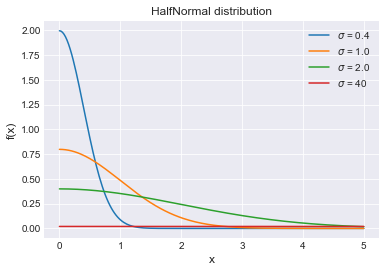

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 5, 200)
for sigma in [0.4, 1., 2., 40]:
    pdf = st.halfnorm.pdf(x, scale=sigma)
    plt.plot(x, pdf, label=r'$\sigma$ = {}'.format(sigma))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.title('HalfNormal distribution')
plt.legend(loc=1)
plt.show()

Definisco la varianza sigma come una distribuzione HalNormal avente come varianza 40. Un valore alto, che appiattisce la distribuzione realizzando una grande dispersione dei dati.

Sia per $mu$ che per $sigma$ ho scelto delle probabilità a priori "poco informative", che riflettono la mia prudenza nel definire un valore preciso di $mu$ e $sigma$.

In [18]:
import pymc3 as pm

In [19]:
with pm.Model():
#     mu = pm.Normal('mu', mu=25, sigma=100)
    mu = pm.Uniform('mu', lower=80, upper=130)               #probabilità a priori di mu
    sigma = pm.HalfNormal('sigma', sigma=40)                 #probabilità a priori di sigma
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=y_obs)   #funzione di verosigmiglianza
    
    trace_m = pm.sample(draws=2000, tune=2000, cores=8, chains=2)  #estrae i campioni (mu,sigma) del modello definito 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:04<00:00, 1824.81draws/s]


In [20]:
pm.densityplot

<function arviz.plots.densityplot.plot_density(data, group='posterior', data_labels=None, var_names=None, credible_interval=0.94, point_estimate='mean', colors='cycle', outline=True, hpd_markers='', shade=0.0, bw=4.5, figsize=None, textsize=None, ax=None, backend=None, backend_kwargs=None, show=None)>

C:\Users\home\Anaconda3\envs\pymc34\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\home\Anaconda3\envs\pymc34\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


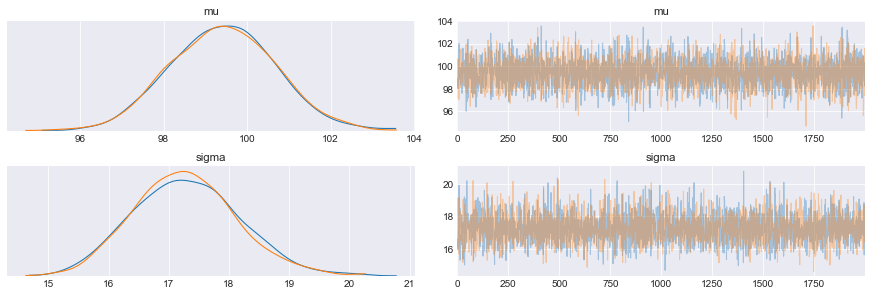

In [21]:
import arviz as az
pm.plot_trace(trace_m)
plt.show()

Si noti come la definizione del modello in Pymc3 è preceduta dallo statement <strong>with pm.Model():</strong>

Ricapitoliamo.
- ho una serie di valori osservati di y, che chiamo y_obs. Dal grafico di y_obs, noto una possibile gaussianità della distribuzione dei valori assunti da y.
- quindi dico y è una variabile con distribuzione normale (gaussiana) con media $mu$ e deviazione standard $sigma$. Purtroppo non conosco né $mu$ né $sigma$, ovvero anche $mu$ e $sigma$ sono due variabili random.
- dall'enunciato sopra risulta che la funzione di verosimiglianza $f(y| mu,sigma )$ è una gaussiana.
- definisco delle distribuzioni a priori per le variabili random $mu$ e $sigma$. Queste riflettono la mia conoscenza del problema. Per $mu$ decido che può essere ovunque nell'intervallo di valori osservati più un fattore di margine 2x. Per $sigma$ definisco una variabilità gaussiana, cioè il valore si muove attorno ad un valore massimo di maggior probabilità. Sembra un'ipotesi ragionevole.  

In sintesi:
\begin{equation}
mu \sim\ Uniform(80, 120)
\end{equation}
\begin{equation}
sigma \sim\ HalfNormal(40)
\end{equation}
\begin{equation}
y| mu,sigma \sim\ Normal(mu, sigma)
\end{equation}

Una volta definito il modello posso campionare -ovvero estrarre dei campioni- dal modello di probabilità a posteriori. Questo si ottiene con la funzione pm.sample() il cui risultato è una traccia del numero di campioni richiesto.
Per esempio nel caso sopra ho usato 

$pm.sample(draws=1000, tune=1000, cores=12, chains=4)$

quindi vengono generate 4 tracce, chiamate chain(s), da 1000 campioni ciascuna.

Si noti che questi campioni appartengono alla distribuzione a posteriori di mu e sigma, ovvero:

\begin{equation}
mu | y\_obs
\end{equation}
\begin{equation}
sigma | y\_obs
\end{equation}

Una cosa generale che può trarre in inganno un occhio inesperto come il mio, è che lo scopo del modello è (tra gli altri) quello di migliorare la conoscenza delle incognite $mu$ e $sigma$, al fine di avere un modello rappresentativo di y.

Ho usato un solo core della mia CPU (cores=1) perché usandone di più ho un messaggio di errore da Python. Sembra essere un bug in windows 10. 

Come si vede dal grafico la funzione a posteriori ha una media $mu$ che è vicina a 100. Mentre l'errore su $sigma$ sembra più alto (pochi punti?).

Vediamo un sommario della distribuzione a posteriori per ogni parametro:

In [22]:
pm.summary(trace_m)

C:\Users\home\Anaconda3\envs\pymc34\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,99.398115,1.244857,0.016646,96.837192,101.664691,4533.777398,0.999781
sigma,17.276695,0.871732,0.013872,15.552160,18.925699,4031.837753,1.000184


C:\Users\home\Anaconda3\envs\pymc34\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\home\Anaconda3\envs\pymc34\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\home\Anaconda3\envs\pymc34\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


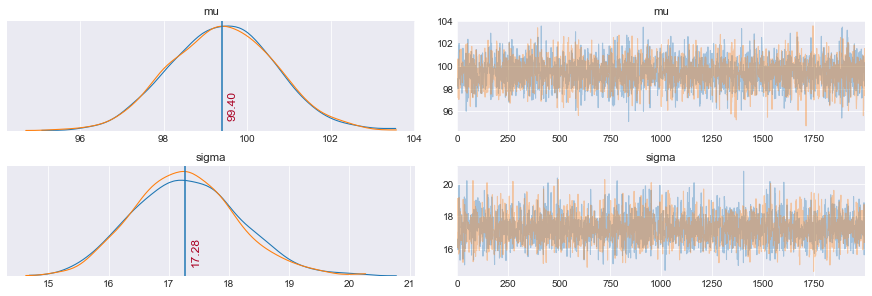

In [23]:
# lines = (('theta_t',{'theta_t_dim_0':0}, [-1]),)
# coords = {'theta_t_dim_0': [0, 1], 'school':['Lawrenceville']}
# az.plot_trace(data, var_names=('theta_t', 'theta'), coords=coords, lines=lines)

# lines = (('mu', {},[100]),)
# ax = pm.traceplot(trace_m, var_names=('mu','sigma'), lines=lines)
ax = pm.traceplot(trace_m, var_names=('mu','sigma'))

ax[0,0].annotate('{:.2f}'.format(pm.summary(trace_m)['mean'].values[0]), xy=(pm.summary(trace_m)['mean'].values[0], 0), 
                 xycoords='data', xytext=(5, 10), textcoords='offset points',
                 rotation=90, va='bottom', fontsize='large', color='#AA0022')
ax[0,0].plot([pm.summary(trace_m)['mean'].values[0],pm.summary(trace_m)['mean'].values[0]], [0,1000])

ax[1,0].annotate('{:.2f}'.format(pm.summary(trace_m)['mean'].values[1]), xy=(pm.summary(trace_m)['mean'].values[1], 0), 
                 xycoords='data', xytext=(5, 10), textcoords='offset points',
                 rotation=90, va='bottom', fontsize='large', color='#AA0022')
ax[1,0].plot([pm.summary(trace_m)['mean'].values[1],pm.summary(trace_m)['mean'].values[1]], [0,1000])

plt.show()

Un'alra cosa utile da sapere è come si chiamano le singole variabili di trace_m

In [24]:
trace_m.varnames

['mu_interval__', 'sigma_log__', 'mu', 'sigma']

Ho estratto 2000 campioni. Ad ogni campione corrisponde un valore di $mu$ e uno di $sigma$.
Per esempio il 1000 campione ha $mu$ e $sigma$ pari a:

In [25]:
trace_m['mu'][1000], trace_m['sigma'][1000]

(99.9988359660078, 17.140641593083924)

Cosa mi dicono i grafici sopra (abbinati al modello)? 

Che $mu$ e $sigma$ sono anch'esse "abbastanza" normali, ciascuno con una media e una varianza che posso ottenere da pm.summary().

In [26]:
pm.summary(trace_m)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,99.398115,1.244857,0.016646,96.837192,101.664691,4533.777398,0.999781
sigma,17.276695,0.871732,0.013872,15.552160,18.925699,4031.837753,1.000184


Che graficamente si può vedere con plot_posterior()

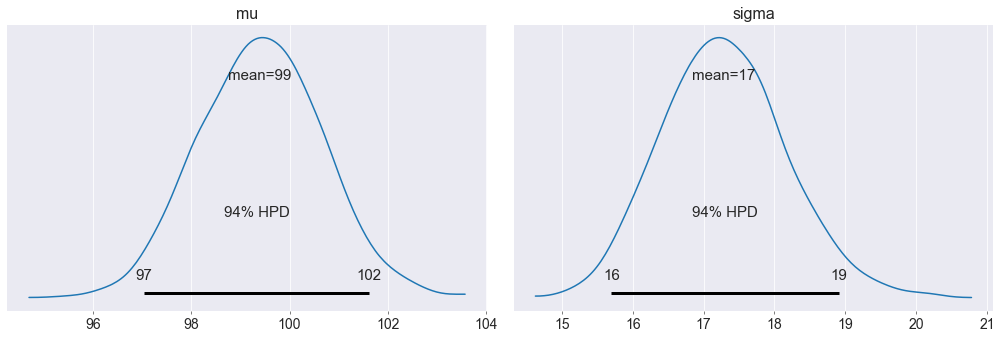

In [27]:
pm.plot_posterior(trace_m)
plt.show()

Quindi a posteriori so che sia $mu$ che $sigma$ sono "abbastanza" normali, ho ottenuto un valor medio che si avvicina molto ai valori che ho usato per generare il dataset. <br>
Ho una deviazione standard anche abbastanza ridotto, per cui sono "abbastanza" certo del valore da assegnare alla mia misura.

Sono arrivato alla conclusione che la mia misura è 100.6 con un intervallo di maggiore densità (97.8,103.3) 

Il valore medio della varianza devia da quello definito (21.4 contro 20), ma è importante notare che la deviazione standard di 20 è dentro l'intervallo di massima probabilità a posteriori [19.4, 23.3]. Quindi rientra a pieno titolo tra i valori possibili. 

Ancora una osservazione da profano. L'errore che faccio assegnando il valore 100.6 alla misura è

In [28]:
errore_misura_bayes = (100.6-100)/100
print('L\'errore di misura è del %0.2f%%' %(errore_misura_bayes*100))

L'errore di misura è del 0.60%


L'errore che avrei fatto se avessi preso semplicemente la media del dataset è molto simile

In [29]:
errore_misura_media = np.mean(y_obs)
print('La media delle osservazioni è del %0.2f' %(errore_misura_media))

La media delle osservazioni è del 99.39


Come si vede la media delle osservazioni è praticamente uguale alla media a posteriori (100.58 vs 100.6). Quello che ho guadagnato con il mio modello bayesiano è un intervallo di confidenza (o credibilità nel caso di statistica bayesiana) per la misura. 

### Predizione con la distribuzione a posteriori

Ridefiniamo lo stesso modello precedente, però stavolta gli diamo un nome: modello_normale (che fantasia?)

In [30]:
with pm.Model() as modello_normale:
#     mu = pm.Normal('mu', mu=25, sigma=100)
    mu = pm.Uniform('mu', lower=80, upper=130)               #probabilità a priori di sigma
    sigma = pm.HalfNormal('sigma', sigma=40)                 #probabilità a priori di sigma
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=y_obs)   #funzione di verosigmiglianza
    
    trace_m = pm.sample(draws=1000, tune=1000, cores=12, chains=2)  #estrae i campioni (mu,sigma) del modello definito 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 12 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 4000/4000 [00:03<00:00, 1247.66draws/s]


Nel grafico è mostrato l' HPD al 94%. <strong>HPD</strong> sta per Highest Posterior Density (massimo intervallo di densità a posteriori). Formalmente è il <strong>più corto</strong> intervallo di credibilità del modello. Ovvero dove si concentra la maggiore (il 94% in questo caso) densità di campioni.<br>
L'intervallo di credibilità al 94% è un intervallo di x tale che Pr(x)>0.03 & Pr(x)<0.997.<br>
Tra la famiglia di intervalli di credibilità al 94% scegliamo quello più corto, dunque avente maggiore densità.

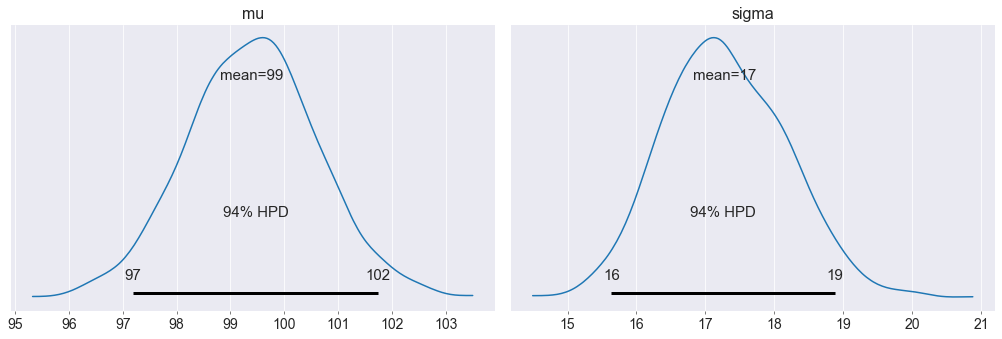

In [31]:
pm.plot_posterior(trace_m)
plt.show()

Adesso generiamo dei campioni per $X$ sulla base delle probabilità a posteriori. Voglio generare 1000 campioni, per ogni campione verranno estratti i valori di $p$ e $sigma$ da $trace\_m$ e con questi parametri viene generato il campione random. Questo viene fatto da **pm.sample_posterior_predictive()**. Posso anche indicare in che formato voglio i campioni, per esempio avrei potuto indicare una matrice 1000x3 con size=(1000,3) 

In [32]:
spp = pm.sample_posterior_predictive(trace_m, samples=1000, model=modello_normale, size=(1000,3))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.99it/s]


Si noti il warning (riportato completo sotto):

        warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
                     "and/or chains may not be represented in the returned posterior "
                     "predictive sample")

Nel generare la probabilità a posteriori ho usato nchains=2 e ndraws=2000, quindi secondo il warning sopra dovrei usare almeno 2x2000=4000 campioni per avere un campione rappresentativo della distribuzione a posteriori. Ci riprovo:

In [33]:
spp = pm.sample_posterior_predictive(trace_m, samples=4000, model=modello_normale)

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1491.42it/s]


In [34]:
spp.keys()

dict_keys(['y'])

C:\Users\home\Anaconda3\envs\pymc34\lib\site-packages\arviz\data\base.py:145: SyntaxWarning: More chains (4000) than draws (200). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,


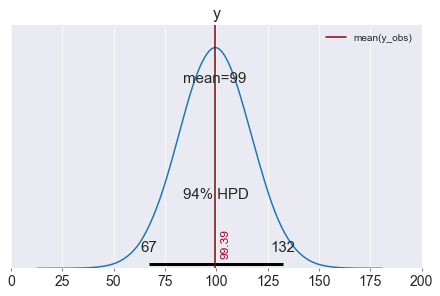

In [35]:
ax = pm.plot_posterior(spp, var_names=['y'], figsize=(6,4), bins=50)

ax[0].annotate('{:.2f}'.format(np.mean(y_obs)), xy=(np.mean(y_obs), 0), 
                 xycoords='data', xytext=(5, 10), textcoords='offset points',
                 rotation=90, va='bottom', fontsize='large', color='#AA0022')

ax[0].plot([np.mean(y_obs),np.mean(y_obs)], [-1,1], color='darkred', label='mean(y_obs)')
# ax[0].hist(y_obs, bins=50)
plt.xlim(0,200)
plt.ylim(0,0.025)
plt.legend()
plt.show()

No handles with labels found to put in legend.


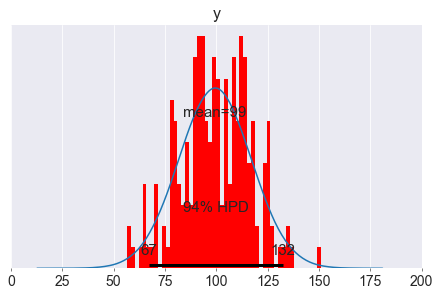

In [36]:
ax = pm.plot_posterior(spp, var_names=['y'],figsize=(6,4), bins=50)

# ax[0].annotate('{:.2f}'.format(np.mean(y_obs)), xy=(np.mean(y_obs), 0), 
#                  xycoords='data', xytext=(5, 10), textcoords='offset points',
#                  rotation=90, va='bottom', fontsize='large', color='#AA0022')
# ax[0].plot([np.mean(y_obs),np.mean(y_obs)], [-1,1], color='darkred', label='mean(y_obs)')
ax[0].hist(y_obs, density=True, bins=50, color="red")
plt.xlim(0,200)
# plt.ylim(0,0.025)
# plt.yticks(np.arange(0,20,5))
plt.legend()
plt.show()

Sopra vediamo la distribuzione (a posteriori) dei dati generati dal modello. La media è vicina alla media dei dati osservati y_obs (100.6 vs 100.58). Quindi il modello è una buona rappresentazione dei dati reali.

## Riferimenti

 1. Il sito ufficiale di [PyMC3](https://docs.pymc.io/)
 2. [Probabilistic programming in Python using PyMC3](https://peerj.com/articles/cs-55/), di John Salvatier, Thomas V. Wiecki, Christopher Fonnesbeck, pubblicato su [PeerJ](https://peerj.com/)
 3. Coursera.org [Bayesian Statistics: From Concept to Data Analysis](https://www.coursera.org/learn/bayesian-statistics)
 4. Cameron Davidson-Pilon, Bayesian Methods for Hackers: Probabilistic Programming and Bayesian Inference, Addison-Wesley Data & Analytics Series, 2015
 5. [Intervalli di credibilità](https://it.qwerty.wiki/wiki/Credible_interval) di una distribuzione
 

## Dipendenze

In [37]:
from platform import python_version
print('Python versione', python_version())
import pandas as pd
print('Pandas versione', pd.__version__)
import numpy as np
print('Numpy versione', np.__version__)
import theano
print('Theano versione', theano.__version__)
import pymc3 as pm
print('PyMC3 versione', pm.__version__)

Python versione 3.7.5
Pandas versione 0.25.3
Numpy versione 1.17.4
Theano versione 1.0.4
PyMC3 versione 3.7
